# Laboratorio 3. Transferencia de Aprendizaje

In [1]:
import numpy as np

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

np.random.seed(12345)

In [2]:
matplotlib.rcParams['figure.figsize'] = 10, 10

En este laboratorio aprenderemos a reutilizar modelos pre-entrenados para adaptarlos a distintos problemas para los cuales fueron entrenados. Las distintas técnicas que se utilizan para tal fin se conocen como *transferencia del aprendizaje*.

La idea general es la siguiente: modelos entrenados en conjuntos grandes de imágenes aprenden representaciones que son en muchos aspectos genéricas y pueden ser reutilizadas para distintas tareas. En modelos composicionales como es el caso de las redes convolucionales modernas, es de esperar que las primeras capas logren capturar características más bien genéricas (locales) mientras que las últimas información más específica al problema para el cual han sido entrenadas. 

La idea de transferencia del aprendizaje es adaptar dichos modelos (la parte específica al nuevo problema) de forma de obtener un buen comportamiento predictivo sin la necesidad de grandes volúmenes de datos.

En este lab vamos a considerar los siguientes casos en el contexto de clasificación de imágenes:

* Parte I: Utilizar una CNN como un extractor de features y entrenar un modelo clásico con scikit-learn.

* Parte II: Adaptación de las últimas capas de la red al nuevo problema.

## Manejo de datos en pytorch

Descargar el archivo de [imágenes](https://download.pytorch.org/tutorial/hymenoptera_data.zip) y descomprimirlo en el directorio actual. El conjunto de datos consiste en un problema de clasificación de imágenes con dos categorías: abejas y hormigas. El mismo ya se encuentra organizado en subconjuntos de entrenamiento y validación.

Si bien es posible manejar datasets arbitrarios, pytorch provee una serie de clases que facilitan la manipulación en problemas mas o menos estándar. Por ejemplo, en el caso de clasificación:

torch.Size([4, 3, 224, 224])
tensor([0, 0, 0, 0])
['ants', 'ants', 'ants', 'ants']


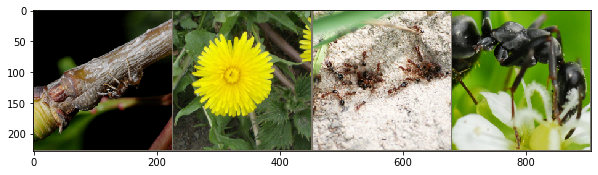

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid

def imshow_tensor(x):
    """
    Función auxiliar para imprimir imágenes (grillas)
    """
    x = x.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = np.clip(std * x + mean, 0, 1) 
    plt.imshow(x)

path = './hymenoptera_data/'

batch_size = 4
num_workers = 2

# Transformaciones que se aplicarán sobre cada imagen:
#   1. el lado más chico de la imagen a 256 pixels manteniendo relación de aspecto (PIL -> PIL)
#   2. crop de la región central de 224x224 pixels (PIL -> PIL)
#   3. transformar la imagen PIL a un tensor de pytorch (PIL -> Tensor)
#   4. aplicar la normalización con la que fueron entrenados los modelos en torchvision  (Tensor -> Tensor)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),    # ¿Que pasa si sacamos esta función? ¿Con batch_size = 1? ¿Porqué?    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# dataset
data = ImageFolder(os.path.join(path, 'train'), transform)

# data loader
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

for image_batch, labels in loader:
    print(image_batch.size())
    print(labels)
    print([data.classes[lbl] for lbl in labels])
    grid = make_grid(image_batch)
    imshow_tensor(grid)
    break

#### Observación

Las dimensiones son **Tamaño_Batch x Canales x Alto x Ancho**.

Como vimos en clases.
Si no se realizara un crop de la región central, no podríamos entrenar por batch ya que las imágenes no tendrían el mismo tamaño, y por lo tanto, no podríamos colocarlas en un tensor.
Con *bach_size = 1* no habría problemas, ya que no tendríamos conflictos de tamaños en el batch.
La única imágen iría directo al tensor.

# Parte I: Modelos Preentrenados como Extractores de Features

Para utilizar una red pre-entrenada para la extracción de features, debemos limitarla a lo que nos interesa. En el caso de ResNet, utilizaremos la salida de la penúltima capa como representación de la imagen.

In [4]:
import torch
from torch import nn
from torchvision import models

# Extractor de Features utilizando ResNet18
# Tamaño de Features: 512
class FeatureExtractor_RN18(nn.Module):
    def __init__(self):
        super().__init__()
        # leer red pre-entrenada
        model = models.resnet18(pretrained=True)
        
        # frizar parámetros
        for p in model.parameters():
            p.requires_grad_(False)
            
        # armar modelo secuencial que incluya todas las capas salvo la última (FC)
        layers = list(model.children())[:-1]
        self.net = nn.Sequential(*layers) 
        
    def forward(self, x):
        N = x.size(0)  # batch size
        x = self.net(x)
        return x.view(N, -1)

# Extractor de Features utilizando ResNet50
# Tamaño de Features: 2048
class FeatureExtractor_RN50(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet50(pretrained=True)
        
        for p in model.parameters():
            p.requires_grad_(False)
            
        layers = list(model.children())[:-1]
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        N = x.size(0)
        x = self.net(x)
        return x.view(N, -1)

# Extractor de Features utilizando VGG16
# Tamaño de Features: 512
class FeatureExtractor_VGG16(nn.Module):
    def __init__(self):        
        super().__init__()
        model = models.vgg16(pretrained=True)
        
        for p in model.parameters():
            p.requires_grad_(False)
            
        # Obtengo la generación de features
        features = model.features
        # Redefino el pooling
        pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # Creo la red completa
        self.net = nn.Sequential(features, pooling) 
        
    def forward(self, x):
        N = x.size(0)
        x = self.net(x)
        return x.view(N, -1)

# Extractor de Features utilizando SP2x2
# Tamaño de Features: 2048
class FeatureExtractor_SP2x2(nn.Module):
    def __init__(self):        
        super().__init__()
        model = models.vgg16(pretrained=True)
        
        for p in model.parameters():
            p.requires_grad_(False)
            
        # Obtengo la generación de features
        features = model.features
        # Grilla 2 x 2
        pooling = nn.AdaptiveAvgPool2d(output_size=(2, 2))
        # Creo la red completa
        self.net = nn.Sequential(features, pooling) 
        
    def forward(self, x):
        N = x.size(0)
        # Obtengo features crudos
        x = self.net(x)
        # Obtengo features de celdas
        feat_1 = x[:, :, 0, 0]
        feat_2 = x[:, :, 0, 1]
        feat_3 = x[:, :, 1, 0]
        feat_4 = x[:, :, 1, 1]
        # Normalizo features de celdas
        feat_1 = feat_1 / torch.norm(feat_1, p=2, dim=1)
        feat_2 = feat_2 / torch.norm(feat_2, p=2, dim=1)
        feat_3 = feat_3 / torch.norm(feat_3, p=2, dim=1)
        feat_4 = feat_4 / torch.norm(feat_4, p=2, dim=1)
        # Concateno features de celdas normalizados
        feature = torch.cat((feat_1, feat_2, feat_3, feat_4), dim=1)
        # Normalizo feature final
        feature = feature / torch.norm(feature, p=2, dim=1)
        
        return feature.view(N, -1)

In [5]:
from tqdm import tqdm_notebook as progressbar

def features_and_labels(set_):
    if set_ not in ('train', 'val'):
        raise ValueError('not a valid data set')
        
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    data = ImageFolder(os.path.join(path, set_), transform)
    
    loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
    
    extractor = FeatureExtractor_SP2x2()
    
    features, labels = [], []
    
    for img, lbl in progressbar(loader):
        feat = extractor(img)
        features.append(feat)
        labels.append(lbl)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels

train_features, train_labels = features_and_labels('train')
val_features, val_labels = features_and_labels('val')
print(train_features.size(), val_features.size())


torch.Size([244, 2048]) torch.Size([153, 2048])


#### Observación
Hay 244 datos de entrenamiento, y 153 datos de validación.

## Selección de modelos con scikit-learn

A continuación veremos cómo sistematizar la selección de hyperparámetros en scikit-learn, tomando como ejemplo en caso de SVMs tanto lineales como no lineales (kernel RBF).

In [6]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)

# Para evitar recomputar los features cada vez, se almacenan a disco
data_set = {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}
np.save("sp2x2.npy", data_set, allow_pickle=True)

my_data = np.load("sp2x2.npy", allow_pickle=True)
x_train = my_data.item().get('x_train')
y_train = my_data.item().get('y_train')
x_test = my_data.item().get('x_test')
y_test = my_data.item().get('y_test')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(244, 2048) (244, 1)
(153, 2048) (153, 1)


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
from utils import plot_confusion_matrix

def print_results(clf, x_test, y_test):
    """
    Función auxiliar para imprimir resultados
    """
    
    print("Best Parameters: {}".format(clf.best_params_))
    print()
    
    print("Grid scores on validation set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print("{:.3f} (+/-{:.3f}) for {}".format(mean, std, param))
    print()
    
    # predictions on test set 
    y_true, y_pred = y_test, clf.predict(x_test)
    
    print("Confusion matrix:")
    print()
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names=['ants', 'bees'])
    
    print("Classification metrics:")
    print()
    print(classification_report(y_true, y_pred, target_names=['ants', 'bees']))

In [9]:
from sklearn.svm import SVC

# parámetros a explorar
parameters = [
    {
        'kernel': ['rbf'], 
        'gamma': [0.1, 1e-2, 1e-3],
        'C': [1, 10, 100, 1000, 1e4]
    },
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    }
]

# 5-fold cross validation
clf = GridSearchCV(SVC(), parameters, cv=5, scoring="accuracy", verbose=1)
clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished
/home/mgobbi289/Documentos/5_Ano/Visión_Computadora/Ambiente/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on validation set:

0.934 (+/-0.032) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.504 (+/-0.005) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.504 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.951 (+/-0.028) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.939 (+/-0.034) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.504 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.939 (+/-0.032) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.947 (+/-0.036) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.939 (+/-0.034) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.939 (+/-0.032) for {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.939 (+/-0.032) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.947 (+/-0.036) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.939 (+/-0.032) for {'C': 10000.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.939 (+/-0.032) for {'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.939 (+/-0.

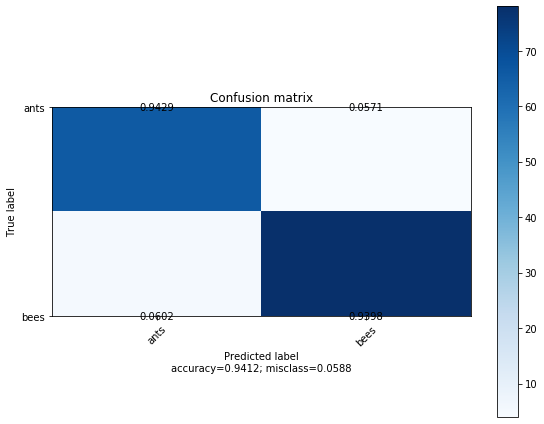

Classification metrics:

              precision    recall  f1-score   support

        ants       0.93      0.94      0.94        70
        bees       0.95      0.94      0.95        83

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



In [10]:
print_results(clf, x_test, y_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

parameters = [
    {
        'metric': ['euclidean', 'manhattan'],
        'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    }
]

clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring="accuracy", verbose=1)
clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
/home/mgobbi289/Documentos/5_Ano/Visión_Computadora/Ambiente/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 5}

Grid scores on validation set:

0.943 (+/-0.015) for {'metric': 'euclidean', 'n_neighbors': 1}
0.951 (+/-0.017) for {'metric': 'euclidean', 'n_neighbors': 3}
0.959 (+/-0.026) for {'metric': 'euclidean', 'n_neighbors': 5}
0.939 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 7}
0.939 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 9}
0.939 (+/-0.031) for {'metric': 'euclidean', 'n_neighbors': 11}
0.939 (+/-0.022) for {'metric': 'euclidean', 'n_neighbors': 13}
0.930 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 15}
0.930 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 17}
0.930 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 19}
0.934 (+/-0.030) for {'metric': 'manhattan', 'n_neighbors': 1}
0.939 (+/-0.026) for {'metric': 'manhattan', 'n_neighbors': 3}
0.943 (+/-0.016) for {'metric': 'manhattan', 'n_neighbors': 5}
0.939 (+/-0.018) for {'metric': 'manhattan', 'n_neighbors': 7}
0.943 (+/-0.015) for 

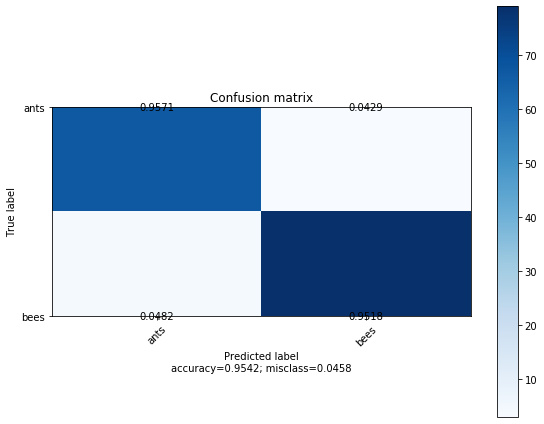

Classification metrics:

              precision    recall  f1-score   support

        ants       0.94      0.96      0.95        70
        bees       0.96      0.95      0.96        83

    accuracy                           0.95       153
   macro avg       0.95      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153



In [12]:
print_results(clf, x_test, y_test)

#### Observación

Utilizando GridSearchCV, se realizan 100 evaluaciones de modelo.
Para **SVM**, hay *15* configuraciones de parámetros para el kernel *RBF*, y *5* para el kernel lineal.
Para **K Neighbors**, hay *2* métricas distintas, y *10* números de vecinos diferentes.
Los datos de entrenamiento se subdividen en *5* subconjuntos en ambos casos.

Algunas métricas utilizadas en el reporte son:
- *Precision* = TP / (TP + FP)
- *Recall*    = TP / (TP + FN)
- *F1 Score*  = 2 * (Precision * Recall) / (Precision + Recall)
- *Accuracy*  = (TP + TN) / (TP + TN + FP + FN)
- *AVG*       = Promedios sin peso y con peso

#### Resultados con SVM

| Features     | ResNet18    | ResNet50     | VGG16        | SP sin Norm  | SP con Norm  |
| ------------ | ------------| ------------ | ------------ | ------------ | ------------ |
| Kernel       | Lineal      | RBF          | RBF          | RBF          | RBF          |
| C            | 1           | 10           | 1            | 10           | 10           |
| Gamma        | -           | 0.1          | 0.001        | 0.001        | 0.1          |
| Accuracy     | **0.6209**  | **0.8235**   | **0.9150**   | **0.8889**   | **0.9412**   |
| TP Ants      | 0.5571      | 0.8714       | 0.9429       | 0.9000       | 0.9429       |
| TP Bees      | 0.6747      | 0.7831       | 0.8916       | 0.8795       | 0.9398       |
| Tiempo Grid  | 2.8 seg     | 11.3 seg     | 2.0 seg      | 10.7 seg     | 6.8 seg      |

#### Resultados con K Neighbors

| Features     | ResNet18    | ResNet50     | VGG16        | SP sin Norm  | SP con Norm  |
| ------------ | ------------| ------------ | ------------ | ------------ | ------------ |
| Métrica      | Euclidea    | Manhattan    | Euclidea     | Euclidea     | Euclidea     |
| Vecinos      | 7           | 7            | 13           | 3            | 5            |
| Accuracy     | **0.6013**  | **0.6732**   | **0.9150**   | **0.8562**   | **0.9542**   |
| TP Ants      | 0.5429      | 0.7429       | 0.9571       | 0.9286       | 0.9571       |
| TP Bees      | 0.6506      | 0.6145       | 0.8795       | 0.7952       | 0.9518       |
| Tiempo Grid  | 1.4 seg     | 4.5 seg      | 1.5 seg      | 4.8 seg      | 4.3 seg      |

#### Conclusiones

A continuación listo mis conclusiones obtenidas en base a los resultados del laboratorio.
Para el caso de la pirámide espacial, realicé dos análisis.
En uno, no aplico ningún tipo de normalización.
En el otro, la normalización es tanto para los features de las celdas, como para el feature final.

- El tiempo de *Grid Search* es proporcional al tamaño del vector de features. Cuando el tamaño es de *512*, se computan más rápidos los modelos en comparación con tamaños de *2048*. Posiblemente, este sea el resultado menos interesante.

- Por lo general, utilizar *SVM* produce mejores resultados a la hora de la clasificación. Esto puede ser debido a que *Neighbors* es un algoritmo más simple y no está diseñado específicamente para clasificación, a diferencia de *SVM*. A pesar de esto, para la selección de modelos el algoritmo de vecinos es más rápido.

- Al parecer es más fácil clasificar hormigas que abejas. Salvo por *ResNet18*, todos los modelos acertaron a mayor porcentaje de hormigas que abejas. Hay que tener en cuenta que en el dataset hay mayor cantidad de ejemplos de abejas que hormigas.

- La elección de parámetros depende fuertemente del diseño del vector de features. Salvo en un par de modelos, nunca se repiten los conjuntos de parámetros ideales.

- De los modelos estudiados en la materia, el mejor extractor de features es el que se basa en la red *VGG16*. Obtiene la mejor *Accuracy*, y los mejores índices de *True Positives*. Además el tamaño del vector de features producido por la red es pequeño.

- La pirámide espacial sin normalización obtiene muy buenos resultados en comparación con *ResNet*. De todas formas, no es tan buena como utilizar *VGG16* puro. Posiblemente al dividir la imágen en secciones, el insecto a clasificar se encuentre solo en algunas partes. Debido a esto, el feature puede terminar con resultados ambigüos donde una sub imágen tiene el insecto, y otra no tiene nada.

- La pirámide espacial con normalización es el mejor extractor de features. Obtiene la mejor *Accuracy*, y los mejores índices de *True Positives*. Esto muestra la importancia de la normalización de features. Supera ampliamente a su versión sin normalización. Posiblemente soluciona el problema hipotético mencionado anteriormente.

- Para la predicción, o más bien la extracción de features, *ResNet18* es la red más veloz. Le siguen *ResNet50*, *VGG16* y finalmente la pirámide espacial. De todas formas, la extracción de features se realiza una sola vez, por lo que el tiempo destinado a esta parte puede no ser tan importante.

## Actividades (I):

* Sobre la importancia de los features:  
  * comparar las siguientes arquitecturas resnet18, resnet50 y vgg16*. 
  * implementar extracción de features mediante una pirámide espacial de 2x2 (partir la imagen de entrada en una grilla de 2x2, extraer features normalizados de cada celda, concatenar y renormalizar). La dimensionalidad de los features resultantes deben ser 4 veces la de los features base.

* Sobre la elección de modelos de clasificación:
  * Evaluar el comportamiento de un classificador de k vecinos (```from sklearn.neighbors import KNeighborsClassifier```) empleando alguno de los features del punto anterior. En este caso, los hiperparámetros a evaluar serán el número de vecinos (3, 5, 7, 9, ...) y la métrica ('euclidean', 'manhattan') de comparación.

(*) en el caso de vgg16, pytorch define los los miembros ``features``, ``avgpool`` y ``classifier``. Utilizar ``features`` y redefinir ``avgpool`` de forma similar a los modelos resnet. 

# Parte II: Finetuning

En esta parte adaptaremos modelo entrenado para resolver un problema particular (p.ej. clasificación sobre ImageNet) a otro de nuestro interés. La idea es la siguiente: tomamos un modelo preentrenado y reemplazamos la última capa (la que define el número de salidas de la red, p.ej, 1000 categorías de ImageNet) con una que se adapte a nuestro problema. Si el número de datos de entrenamiento disponibles para el nuevo problema es chico, adaptaremos únicamente ésta última capa de la red. Si éste número es mayor, podemos adaptar más capas (en general, desde la salida hacia la entrada). La forma de seleccionar que parámetros (capas) adaptaremos y cuáles no, es seteando el atributo ```requieres_grad``` de cada nodo al valor deseado. Únicamente aquellos nodos que tengan éste atributo en ```True``` serán adaptados durante el proceso de optimización. A continuación exploraremos esta idea mediante la definición de un modelo adaptado al problema de abejas y hormigas (2 clases).

In [ ]:
# carga de modelo preentrenado
model = models.resnet18(pretrained=True)

# freezar todos los parámetros
for p in model.parameters():
    p.requires_grad_(False)

# reemplazamos la última capa lineal por una nueva adaptada a nuestro problema. 
# En el caso de los modelos resnet en pytorch, la última capa lineal corresponde al miembro .fc
in_features = model.fc.in_features
num_classes = 2
model.fc = nn.Linear(in_features, num_classes)

# guardar la lista de parámetros a actualizar que pasaremos al optimizador
parameters_to_update = [p for p in model.parameters() if p.requires_grad]

Con el modelo definido, resta armar el resto de la estructura de entrenamiento (data loaders, funciones de costo y optimización)

In [ ]:
batch_size = 32
num_workers = 4

# data transforms 
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),  # data augmentation!
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dataset splits
data = {
    'train': ImageFolder(os.path.join(path, 'train'), data_transform['train']),
    'val': ImageFolder(os.path.join(path, 'val'), data_transform['val'])
}    

# dataloaders
data_loader = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

# criterio de optimización
criterion = nn.CrossEntropyLoss()  # combina LogSoftmax + NLLLoss

# Optimizador
optimizer = torch.optim.Adam(parameters_to_update, lr=1.0)

In [ ]:
def train(model, data_loader, criterion, optimizer, device):            
    running_loss = 0.
    running_acc = 0.
       
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
           
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(preds == labels.data)
                
    running_loss /= len(data_loader.dataset)
    running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc                

def validate(model, data_loader, criterion, device):            
    running_loss = 0.
    running_acc = 0.
       
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
           
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(preds == labels.data)
                
    running_loss /= len(data_loader.dataset)
    running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc  

In [ ]:
from tqdm import tqdm_notebook as progressbar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

num_epochs = 10

for epoch in progressbar(range(1, num_epochs+1)):
        train_loss, train_acc = train(model, data_loader['train'], criterion, optimizer, device)
        
        val_loss, val_acc = validate(model, data_loader['val'], criterion, device)
        
        print('[{}] loss: train={:.3f}, val={:.3f} -- accuracy: train={:.3f}, val={:.3f}'.format(epoch, train_loss, val_loss, train_acc, val_acc))

## Actividades (II):

* Con las capas freezadas, encontrar rangos de valores razonables para el learning_rate. Observar evolución de la función de costo ("train" y "val") para guiar la búsqueda y selección.

* Implementar esquemas de data augmentation más agresivos durante el entrenamiento (p.ej. rotaciones o crops aleatorios, etc.). Ver transformaciones disponibles [acá](https://pytorch.org/docs/stable/torchvision/transforms.html).

* Configurar la red para adaptar todos sus parámetros y reentrenar.

* (opcional) De contar con disponibilidad de GPUs, probar cambiando la arquitectura a una más compleja (resnet50, vgg16).
